In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import xgboost as xg

In [7]:
# Read in the file
Clv = pd.read_csv("FutureMargin1.csv")

In [8]:
# Exploration of the sales data
print(Clv.head(10))
type(Clv)

# Data Understanding
    # id: identification number of customer
    # nOrders: Number of orders by the customer
    # nItems: Total number of items ordered by the customers across order; each order may have multiple items
    # daysSinceLastOrder: Number of days since the last order
    # margin: Mean margin aggregated across orders
    # returnRatio: ratio of orders returned by the customers to total orders
    # shareOwnBrand: Percentage of private label 
    # shareVoucher: Sales from voucher
    # shareSale: Voucher related sales
    # gender, age: Demographics
    # marginPerOrder: Margin per order aggregated
    # marginPerItem: margin per item aggregated
    # itemsPerOrder: mean items per order
    # futureMargin: Target variable

   customerID  nOrders  nItems  daysSinceLastOrder  margin  returnRatio  \
0           2        4       7                   4   35.77         0.25   
1           3        3       4                 272   25.74         0.44   
2           4       12      25                  12   63.32         0.15   
3           5       16      29                  32   53.74         0.03   
4           6        1       2                  47   35.85         0.00   
5           7        2       8                  19   22.02         0.18   
6           8        3       4                  63    8.93         0.00   
7           9       15      20                  23   43.54         0.01   
8          10       16      18                  75   55.14         0.02   
9          11        1       2                 193   13.44         1.00   

   shareOwnBrand  shareVoucher  shareSale  gender  age  marginPerOrder  \
0           0.67          0.17       0.00  female   56            8.94   
1           0.33          

pandas.core.frame.DataFrame

In [9]:
# Checking the data type across the data set 

Clv.dtypes
    # The data types across variables. Only categorical variable is Gender.


customerID              int64
nOrders                 int64
nItems                  int64
daysSinceLastOrder      int64
margin                float64
returnRatio           float64
shareOwnBrand         float64
shareVoucher          float64
shareSale             float64
gender                 object
age                     int64
marginPerOrder        float64
marginPerItem         float64
itemsPerOrder         float64
futureMargin          float64
dtype: object

In [10]:
# Check if any values are missing
Clv.isnull().values.any()
        # No missing data in any of the variables

False

In [11]:
# correlation of the target variable - future margin with other variables in the dataset
Clv.corr()["futureMargin"]
    # Margin has the highest correlation with future margin
    # Number of orders and number of items are highly correlated with future margin
    # Interesting to note that margin per order and margin per item is negatively correlated with future margin 

customerID            0.029413
nOrders               0.427384
nItems                0.460728
daysSinceLastOrder   -0.340411
margin                0.562080
returnRatio          -0.283647
shareOwnBrand         0.342157
shareVoucher         -0.112116
shareSale            -0.121843
age                   0.021976
marginPerOrder       -0.144447
marginPerItem        -0.213491
itemsPerOrder         0.158894
futureMargin          1.000000
Name: futureMargin, dtype: float64

(array([5.000e+00, 1.700e+01, 3.700e+01, 6.070e+02, 1.057e+03, 7.570e+02,
        5.920e+02, 4.050e+02, 2.310e+02, 1.660e+02, 1.000e+02, 6.800e+01,
        5.500e+01, 3.500e+01, 1.900e+01, 1.800e+01, 1.100e+01, 8.000e+00,
        1.000e+00, 2.000e+00]),
 array([-7.45  , -4.6165, -1.783 ,  1.0505,  3.884 ,  6.7175,  9.551 ,
        12.3845, 15.218 , 18.0515, 20.885 , 23.7185, 26.552 , 29.3855,
        32.219 , 35.0525, 37.886 , 40.7195, 43.553 , 46.3865, 49.22  ]),
 <a list of 20 Patch objects>)

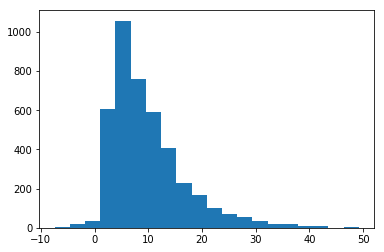

In [12]:
# histogram of margin per order

plt.figure()

%matplotlib inline
plt.hist(Clv['marginPerOrder'], bins=20)

# Negative correlation because the number of order and items (positively correlated with future margins) are in the denominator


In [13]:
# Multi-collinearity

Clv.corr()

    # Number of orders and number of items are highly correlated
    # Correlation between margin and number of orders and items are also fairly high

# calculate VIF



,customerID,nOrders,nItems,daysSinceLastOrder,margin,returnRatio,shareOwnBrand,shareVoucher,shareSale,age,marginPerOrder,marginPerItem,itemsPerOrder,futureMargin
customerID,1.000000,-0.007588,0.001762,-0.061271,-0.008254,-0.000916,0.029921,-0.023285,-0.016064,0.041121,0.015370,0.007522,0.008029,0.029413
nOrders,-0.007588,1.000000,0.904145,-0.405087,0.688963,-0.326346,0.140015,-0.051942,-0.069808,0.069661,-0.499974,-0.453122,-0.006125,0.427384
nItems,0.001762,0.904145,1.000000,-0.403181,0.740434,-0.376072,0.178736,-0.083293,-0.089800,0.036171,-0.419090,-0.495651,0.280555,0.460728
daysSinceLastOrder,-0.061271,-0.405087,-0.403181,1.000000,-0.456478,0.209475,-0.140386,0.095135,0.033587,-0.034900,0.289441,0.318106,-0.083191,-0.340411
margin,-0.008254,0.688963,0.740434,-0.456478,1.000000,-0.434104,0.422858,-0.174867,-0.144041,0.062940,-0.119030,-0.285247,0.316370,0.562080
returnRatio,-0.000916,-0.326346,-0.376072,0.209475,-0.434104,1.000000,-0.144945,0.026975,0.022218,-0.001765,0.140114,0.289150,-0.270679,-0.283647
shareOwnBrand,0.029921,0.140015,0.178736,-0.140386,0.422858,-0.144945,1.000000,-0.113124,-0.108956,-0.001990,0.182246,0.121799,0.103041,0.342157
shareVoucher,-0.023285,-0.051942,-0.083293,0.095135,-0.174867,0.026975,-0.113124,1.000000,-0.271549,0.096969,-0.086293,-0.022005,-0.093538,-0.112116
shareSale,-0.016064,-0.069808,-0.089800,0.033587,-0.144041,0.022218,-0.108956,-0.271549,1.000000,-0.064350,-0.057861,-0.021295,-0.063936,-0.121843
age,0.041121,0.069661,0.036171,-0.034900,0.062940,-0.001765,-0.001990,0.096969,-0.064350,1.000000,-0.030334,-0.031242,-0.030697,0.021976


In [353]:
Clv = Clv.drop(['gender'], axis=1)
Clv = Clv.drop(['customerID'], axis=1)

# Split the data into training/testing sets
clv_X_train = Clv[:-20]
clv_X_test = Clv[-20:]


# Split the targets into training/testing sets
clv_y_train = Clv.futureMargin[:-20]
clv_y_test = Clv.futureMargin[-20:]


clv_X_train = clv_X_train.drop('futureMargin', axis=1)
clv_X_test = clv_X_test.drop('futureMargin', axis=1)


# Create linear regression object
regr = sk.linear_model.LinearRegression()

clv_X_train.head(5)

,nOrders,nItems,daysSinceLastOrder,margin,returnRatio,shareOwnBrand,shareVoucher,shareSale,age,marginPerOrder,marginPerItem,itemsPerOrder
0,4,7,4,35.77,0.25,0.67,0.17,0.00,56,8.94,5.11,1.75
1,3,4,272,25.74,0.44,0.33,0.00,0.67,37,8.58,6.43,1.33
2,12,25,12,63.32,0.15,0.86,0.38,0.29,32,5.28,2.53,2.08
3,16,29,32,53.74,0.03,0.96,0.17,0.33,43,3.36,1.85,1.81
4,1,2,47,35.85,0.00,1.00,0.00,1.00,48,35.85,17.93,2.00


In [354]:

# Train the model using the training sets
regr.fit(clv_X_train, clv_y_train)

# Make predictions using the testing set
clv_y_pred = regr.predict(clv_X_test)



In [355]:
for idx, col_name in enumerate(clv_X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regr.coef_[idx]))

The coefficient for nOrders is -0.02714423203320219
The coefficient for nItems is 0.13549854101637476
The coefficient for daysSinceLastOrder is -0.01640639882275302
The coefficient for margin is 0.4019208006497009
The coefficient for returnRatio is -1.9030018261089496
The coefficient for shareOwnBrand is 7.697141563602516
The coefficient for shareVoucher is -1.789768157826989
The coefficient for shareSale is -2.8852533646348397
The coefficient for age is -0.00924264977081293
The coefficient for marginPerOrder is -0.2025025413934958
The coefficient for marginPerItem is 0.019418764672775687
The coefficient for itemsPerOrder is 0.10757892042478014


In [356]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(clv_y_test, clv_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(clv_y_test, clv_y_pred))


Mean squared error: 111.90
Variance score: 0.55


In [357]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Clv.values, i) for i in range(Clv.shape[1])]
vif["features"] = Clv.columns
vif.round()

,VIF Factor,features
0,18.0,nOrders
1,20.0,nItems
2,3.0,daysSinceLastOrder
3,18.0,margin
4,3.0,returnRatio
5,2.0,shareOwnBrand
6,2.0,shareVoucher
7,2.0,shareSale
8,9.0,age
9,23.0,marginPerOrder


In [360]:
# Dropping nItems as it is heavily correlated with nOrders

Clv1 = Clv.drop('futureMargin', axis=1)
Clv2 = Clv1.drop('nItems', axis=1)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Clv2.values, i) for i in range(Clv2.shape[1])]
vif["features"] = Clv2.columns
vif.round()

,VIF Factor,features
0,5.0,nOrders
1,3.0,daysSinceLastOrder
2,16.0,margin
3,3.0,returnRatio
4,2.0,shareOwnBrand
5,2.0,shareVoucher
6,2.0,shareSale
7,8.0,age
8,19.0,marginPerOrder
9,13.0,marginPerItem


In [367]:
# Removing marginperorder, marginperitem, and itemsperorder as they are all highly correlated with margins or orders; decided to retain raw margins and take off the margin related calculated fields

Clv3 = Clv2.drop('marginPerOrder', axis=1)
Clv4 = Clv3.drop('marginPerItem', axis=1)
Clv5 = Clv4.drop('age', axis=1)
Clv6 = Clv5.drop('nOrders', axis=1)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Clv6.values, i) for i in range(Clv6.shape[1])]
vif["features"] = Clv6.columns
vif.round()


,VIF Factor,features
0,2.0,daysSinceLastOrder
1,5.0,margin
2,2.0,returnRatio
3,2.0,shareOwnBrand
4,2.0,shareVoucher
5,2.0,shareSale
6,4.0,itemsPerOrder


In [366]:
# Checking assumptions of normality
Clv.head(5)
model = smf.ols("futureMargin ~ daysSinceLastOrder + margin + returnRatio +  shareOwnBrand + shareVoucher + shareSale + itemsPerOrder", data = Clv).fit()
model.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>      <td>futureMargin</td>   <th>  R-squared:         </th> <td>   0.345</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.343</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   314.1</td> 
</tr>
<tr>
  <th>Date:</th>             <td>Mon, 22 Apr 2019</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>00:16:17</td>     <th>  Log-Likelihood:    </th> <td> -16987.</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  4191</td>      <th>  AIC:               </th> <td>3.399e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  4183</td>      <th>  BIC:               </th> <td>3.404e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     7</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
           <td></td>             <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>Intercept</th>          <td>   20.6565</td> <td>    1.035</td> <td>   19.951</td> <td> 0.000</td> <td>   18.627</td> <td>   22.686</td>
</tr>
<tr>
  <th>daysSinceLastOrder</th> <td>   -0.0210</td> <td>    0.003</td> <td>   -8.042</td> <td> 0.000</td> <td>   -0.026</td> <td>   -0.016</td>
</tr>
<tr>
  <th>margin</th>             <td>    0.4848</td> <td>    0.020</td> <td>   24.256</td> <td> 0.000</td> <td>    0.446</td> <td>    0.524</td>
</tr>
<tr>
  <th>returnRatio</th>        <td>   -2.5736</td> <td>    0.598</td> <td>   -4.306</td> <td> 0.000</td> <td>   -3.745</td> <td>   -1.402</td>
</tr>
<tr>
  <th>shareOwnBrand</th>      <td>    6.1966</td> <td>    0.651</td> <td>    9.522</td> <td> 0.000</td> <td>    4.921</td> <td>    7.472</td>
</tr>
<tr>
  <th>shareVoucher</th>       <td>   -1.2988</td> <td>    0.666</td> <td>   -1.951</td> <td> 0.051</td> <td>   -2.604</td> <td>    0.006</td>
</tr>
<tr>
  <th>shareSale</th>          <td>   -2.5821</td> <td>    0.692</td> <td>   -3.729</td> <td> 0.000</td> <td>   -3.940</td> <td>   -1.224</td>
</tr>
<tr>
  <th>itemsPerOrder</th>      <td>   -0.3360</td> <td>    0.227</td> <td>   -1.483</td> <td> 0.138</td> <td>   -0.780</td> <td>    0.108</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>43.270</td> <th>  Durbin-Watson:     </th> <td>   1.958</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td>  44.400</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.252</td> <th>  Prob(JB):          </th> <td>2.28e-10</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 3.030</td> <th>  Cond. No.          </th> <td>    755.</td>
</tr>
</table><br/><br/>Warnings:<br/>[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

Text(0.5, 1.0, 'Model1 Residuals Probability Plot')

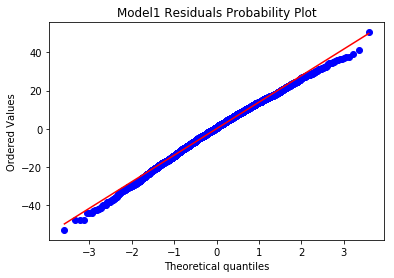

In [370]:
stats.probplot(model.resid, plot= plt)
plt.title("Model1 Residuals Probability Plot")

# Residuals are normally distributed! Woot! Hence inference tests can be used

In [376]:
# Homoscedasticity or constant variance of residuals

TestNames = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(TestNames, test)

[('Lagrange multiplier statistic', 50.538436619318034),
 ('p-value', 1.132276897461077e-08),
 ('f-value', 7.293951484895316),
 ('f p-value', 1.0155262039588108e-08)]

In [377]:

# Split the data into training/testing sets
clv_X_train = Clv6[:-20]
clv_X_test = Clv6[-20:]


# Split the targets into training/testing sets
clv_y_train = Clv.futureMargin[:-20]
clv_y_test = Clv.futureMargin[-20:]


# Create linear regression object
regr = sk.linear_model.LinearRegression()

clv_X_train.head(5)

,daysSinceLastOrder,margin,returnRatio,shareOwnBrand,shareVoucher,shareSale,itemsPerOrder
0,4,35.77,0.25,0.67,0.17,0.00,1.75
1,272,25.74,0.44,0.33,0.00,0.67,1.33
2,12,63.32,0.15,0.86,0.38,0.29,2.08
3,32,53.74,0.03,0.96,0.17,0.33,1.81
4,47,35.85,0.00,1.00,0.00,1.00,2.00


In [378]:

# Train the model using the training sets
regr.fit(clv_X_train, clv_y_train)

# Make predictions using the testing set
clv_y_pred = regr.predict(clv_X_test)

In [379]:
for idx, col_name in enumerate(clv_X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regr.coef_[idx]))
	

The coefficient for daysSinceLastOrder is -0.02096471010150618
The coefficient for margin is 0.48415516083381793
The coefficient for returnRatio is -2.5325465192643777
The coefficient for shareOwnBrand is 6.225078633624859
The coefficient for shareVoucher is -1.258871992915651
The coefficient for shareSale is -2.5137138644744064
The coefficient for itemsPerOrder is -0.33686282092694286


In [380]:
# R squared
print("R squared: %.2f"
       % regr.score(clv_X_test, clv_y_test))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(clv_y_test, clv_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(clv_y_test, clv_y_pred))

R squared: 0.56
Mean squared error: 110.43
Variance score: 0.56


In [381]:
# making predictions
ClvPredict = pd.read_csv('FutureMargin2.csv')
ClvPredict = ClvPredict.drop(['customerID','nOrders','nItems','gender','marginPerOrder','marginPerItem','age'], axis=1)
ClvPredict.head(10)
type(ClvPredict)
ClvPredict.dtypes


daysSinceLastOrder    float64
margin                float64
returnRatio           float64
shareOwnBrand         float64
shareVoucher          float64
shareSale             float64
itemsPerOrder         float64
dtype: object

In [382]:
# Missing values
ClvPredict.isnull().values.any()
ClvPredict = ClvPredict.dropna()

In [383]:
ClvPredict.isnull().values.any()

False

In [384]:
# Testing before passing through predict
ClvPredict.shape

(4010, 7)

In [ ]:
# Calculating the model output as per prediction

ClvResults = regr.predict(ClvPredict)
ClvResults = pd.DataFrame(ClvResults)
ClvResults.head(10)






In [34]:
### XG Boost for predicting the future margin


# Read in the file
ClvXg = pd.read_csv("FutureMargin1.csv")
ClvXg.head(10)
ClvXg1 = ClvXg.drop(['gender'], axis=1)
ClvXg2 = ClvXg1.drop(['customerID'], axis=1)


In [36]:
# Creating train and test data set  
X, y = ClvXg2.iloc[:,:-1],ClvXg2.iloc[:,-1]

X_train, X_test, y_train, y_test= train_test_split(X, y,
        test_size=0.2, random_state=123)


X_train.head(2)

,nOrders,nItems,daysSinceLastOrder,margin,returnRatio,shareOwnBrand,shareVoucher,shareSale,age,marginPerOrder,marginPerItem,itemsPerOrder
3973,7,13,44,31.38,0.83,0.09,0.36,0.27,49,4.48,2.41,1.86
1729,2,2,88,13.55,0.25,0.00,0.00,0.50,28,6.78,6.78,1.00


In [60]:
# Running the XG Boost model

import xgboost as xgb 

xg_reg = xgb.XGBRegressor(objective='reg:linear',n_estimators=25, seed=123)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)



C:\Users\Diya Abraham\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [61]:
# Results

rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

RMSE: 14.175429


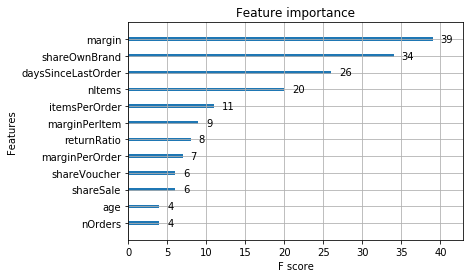

In [62]:

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

XGBoostError: b'[12:03:08] C:\\Users\\Administrator\\Desktop\\xgboost\\src\\gbm\\gbm.cc:20: Unknown gbm type glb:linear'

ValueError: Feature importance is not defined for Booster type gblinear